In [1]:
import pandas as pd
import numpy as np
import os, glob
import re
import string
import warnings
import time
import datetime
import random
import bs4
import requests
import spacy
from spacy import displacy

import io
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
from tqdm import tqdm, trange

%matplotlib inline

import utils 
import config
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

from wordcloud import WordCloud
import plotly.figure_factory as ff
import matplotlib.pyplot as plt


import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

2023-02-04 16:16:21.193873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eugeneolkhovik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# deal with eventual warnings and set seedwarnings.filterwarnings('ignore') 
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
np.random.seed(1863)

is_truncated flag was made to work with chunck of the data because it took too much time, firstly we took 1000 reviews. But training BERT without GPU acceleration is very consuming in time and computational power, so chunck size was reduce to 50 reviews to run it faster and demostrate that our code works fine. Probably, final version will have more data.

In [4]:
#config.SEED
SEED = 1863
random.seed(config.SEED)
np.random.seed(config.SEED)
torch.manual_seed(config.SEED)
torch.cuda.manual_seed_all(config.SEED)

device = utils.get_device()

In [5]:
neg_df = utils.read_data(config.NEGATIVE_REVIEWS_FOLDER_PATH, is_truncated=True)
pos_df = utils.read_data(config.POSITIVE_REVIEWS_FOLDER_PATH, is_truncated=True)
unsup_df = utils.read_data(config.UNSUPERVISED_FOLDER_PATH, is_truncated=True)

We have 12500 for negative and positive reviews and 50000 unsupervised reviews

In [6]:
neg_df.shape, pos_df.shape, unsup_df.shape

((500, 1), (500, 1), (500, 1))

##### Firstly, after looking through HTML hashtags were found, so using regex remove them from each review and each dataframe

In [7]:


neg_df['review'] = neg_df['review'].apply(utils.clean_html)
pos_df['review'] = pos_df['review'].apply(utils.clean_html)
unsup_df['review'] = unsup_df['review'].apply(utils.clean_html)

Lemmatization apply for negative and positive revies

In [8]:
neg_df['review'] = neg_df['review'].apply(utils.get_lemmatization)
pos_df['review'] = pos_df['review'].apply(utils.get_lemmatization)

World clouds for positive and negative are almost the same 

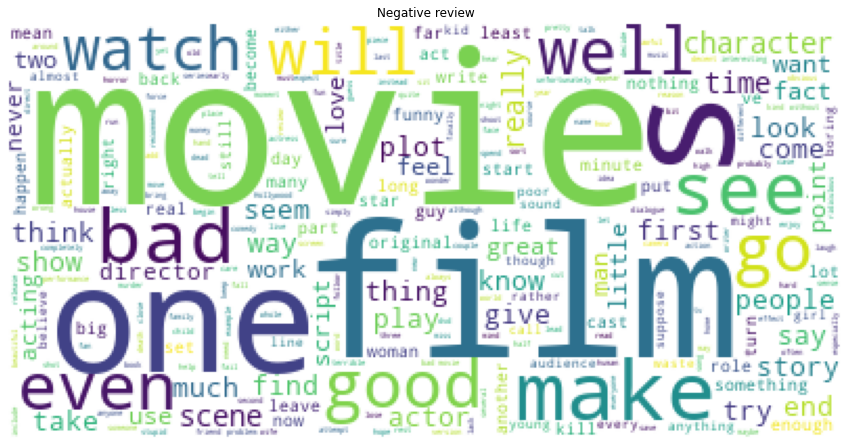

In [9]:

plt.subplots(figsize = (15, 15))
long_string = ','.join(list(neg_df['review'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=10, contour_color='steelblue')
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Negative review')
plt.show()

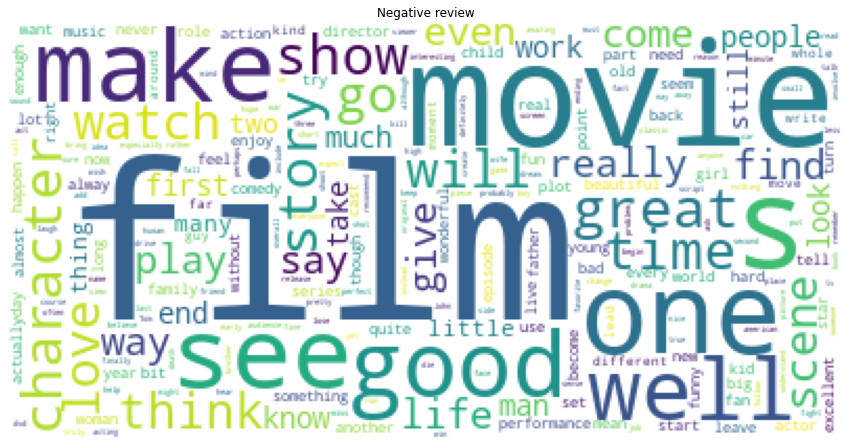

In [10]:

plt.subplots(figsize = (15, 15))
long_string = ','.join(list(pos_df['review'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=10, contour_color='steelblue')
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Negative review')
plt.show()

In [11]:
neg_df['sentiment'] = 0
pos_df['sentiment'] = 1
full_review_df = pd.concat([neg_df,pos_df], ignore_index=True)

#### Topics exploration 
Before we trained benckmark model for classification we processed topic modeling separatly for negative reviews and positive

In [12]:
count_vect_neg = CountVectorizer(max_df=0.5, min_df=10, stop_words='english', analyzer=utils.get_full_text_process)
doc_term_matrix_neg = count_vect_neg.fit_transform(neg_df['review'].values.astype('U'))

count_vect_pos = CountVectorizer(max_df=0.5, min_df=10, stop_words='english', analyzer=utils.get_full_text_process)
doc_term_matrix_pos = count_vect_pos.fit_transform(pos_df['review'].values.astype('U'))

From most common words in topics it is hardly visible the difference between positive and negative reviews. We can notice that negative words sometimes appear in topics from nagative reviews

In [13]:
LDA_neg = TruncatedSVD(n_components=10, random_state=1863, n_iter=50)
LDA_pos = TruncatedSVD(n_components=10, random_state=1863, n_iter=50)
LDA_neg.fit(doc_term_matrix_neg)
LDA_pos.fit(doc_term_matrix_pos)


TruncatedSVD(n_components=10, n_iter=50, random_state=1863)

In [14]:
for i,topic in enumerate(LDA_neg.components_):
    print(f'Top 10 words for negative topic #{i+1}:')
    print([count_vect_neg.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for negative topic #1:
['scene', 'time', 'go', 'well', 'even', 'good', 'character', 'get', 'would', 'bad']


Top 10 words for negative topic #2:
['shot', 'time', 'stick', 'move', 'right', 'seem', 'much', 'James', 'game', 'character']


Top 10 words for negative topic #3:
['home', 'mother', 'real', 'role', 'two', 'look', 'day', 'wife', 'good', 'James']


Top 10 words for negative topic #4:
['move', 'impressive', 'look', 'shot', 'stick', 'seem', 'character', 'game', 'James', 'bad']


Top 10 words for negative topic #5:
['scene', 'gay', 'get', 'fact', 'ever', 'say', 'bad', 'think', 'James', 'would']


Top 10 words for negative topic #6:
['watch', 'show', 'story', 'good', 'many', 'play', 'leave', 'novel', 'character', 'scene']


Top 10 words for negative topic #7:
['murder', 'plot', 'woman', 'scene', 'child', 'give', 'find', 'little', 'kill', 'bad']


Top 10 words for negative topic #8:
['ever', 'novel', 'would', 'far', 'use', 'many', 'show', 'time', 'say', 'good']


Top 10 wo

In [15]:
for i,topic in enumerate(LDA_pos.components_):
    print(f'Top 10 words for negative topic #{i+1}:')
    print([count_vect_pos.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for negative topic #1:
['show', 'time', 'great', 'would', 'get', 'character', 'well', 'good', 'like', 'make']


Top 10 words for negative topic #2:
['say', 'game', 'cool', 'story', 'well', 'car', 'get', 'would', 'great', 'good']


Top 10 words for negative topic #3:
['say', 'watch', 'well', 'though', 'tv', 'would', 'series', 'good', 'episode', 'show']


Top 10 words for negative topic #4:
['story', 'also', 'time', 'include', 'World', 'war', 'War', 'great', 'series', 'episode']


Top 10 words for negative topic #5:
['series', 'man', 'car', 'watch', 'get', 'like', 'episode', 'say', 'make', 'would']


Top 10 words for negative topic #6:
['nice', 'character', 'want', 'game', 'thing', 'get', 'love', 'really', 'great', 'like']


Top 10 words for negative topic #7:
['much', 'character', 'series', '10', 'well', 'Disney', 'give', 'episode', 'make', 'point']


Top 10 words for negative topic #8:
['try', 'give', 'way', 'go', 'car', 'leave', 'find', 'love', 'time', 'get']


Top 10 wor

### Knowledge Graph 
Node A and Node B here are two different entities. These nodes are connected by an edge that represents the relationship between the two nodes. Now, this is the smallest knowledge graph we can build – it is also known as a triple.Knowledge Graph’s come in a variety of shapes and sizes. To build a knowledge graph from the text, it is important to make our machine understand natural language. This can be done by using NLP techniques such as sentence segmentation, dependency parsing, parts of speech tagging, and entity recognition.

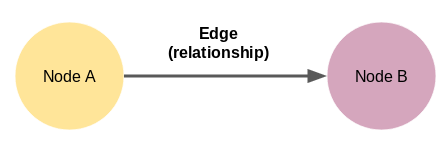

To build the graph firstly we need to make segmentation of the sentences and we will keep only those sentences which have 1 relationship between object and subject. Extracting subjects and objects (most commonly it is two nouns) is not a complicated task, it can be done with parts of speech (POS) tags. However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence.

We took function for subject and object extraction from a sentence which deals with problem mentioned above. It splits a sentence on chunks amd checks if a chunk is a punctuation, part of a compaund word and etc.

In [16]:
neg_reviews_pairs = [utils.get_entities(i) for i in tqdm(neg_df["review"])]

100%|██████████| 500/500 [00:16<00:00, 30.26it/s]


In [17]:
pos_reviews_pairs = [utils.get_entities(i) for i in tqdm(pos_df["review"])]

100%|██████████| 500/500 [00:15<00:00, 31.62it/s]


In [18]:
neg_relations = [utils.get_relation(i) for i in tqdm(neg_df["review"])]

100%|██████████| 500/500 [00:16<00:00, 31.21it/s]


In [19]:
pos_relations = [utils.get_relation(i) for i in tqdm(pos_df["review"])]

100%|██████████| 500/500 [00:15<00:00, 32.39it/s]


In [20]:
pd.Series(pos_relations).value_counts()[:20]

be           124
recommend     25
see           11
have          10
think          8
love           7
do             6
8/10           6
thank          6
like           6
watch          5
make           5
say            5
give           5
enjoy          5
10/10          5
go             4
need           4
get            4
movie          4
dtype: int64

In [21]:
neg_source = [i[0] for i in neg_reviews_pairs]
neg_target = [i[1] for i in neg_reviews_pairs]
neg_kg_df = pd.DataFrame({'source':neg_source, 'target':neg_target, 'edge':neg_relations})

pos_source = [i[0] for i in pos_reviews_pairs]
pos_target = [i[1] for i in pos_reviews_pairs]
pos_kg_df = pd.DataFrame({'source':pos_source, 'target':pos_target, 'edge':pos_relations})

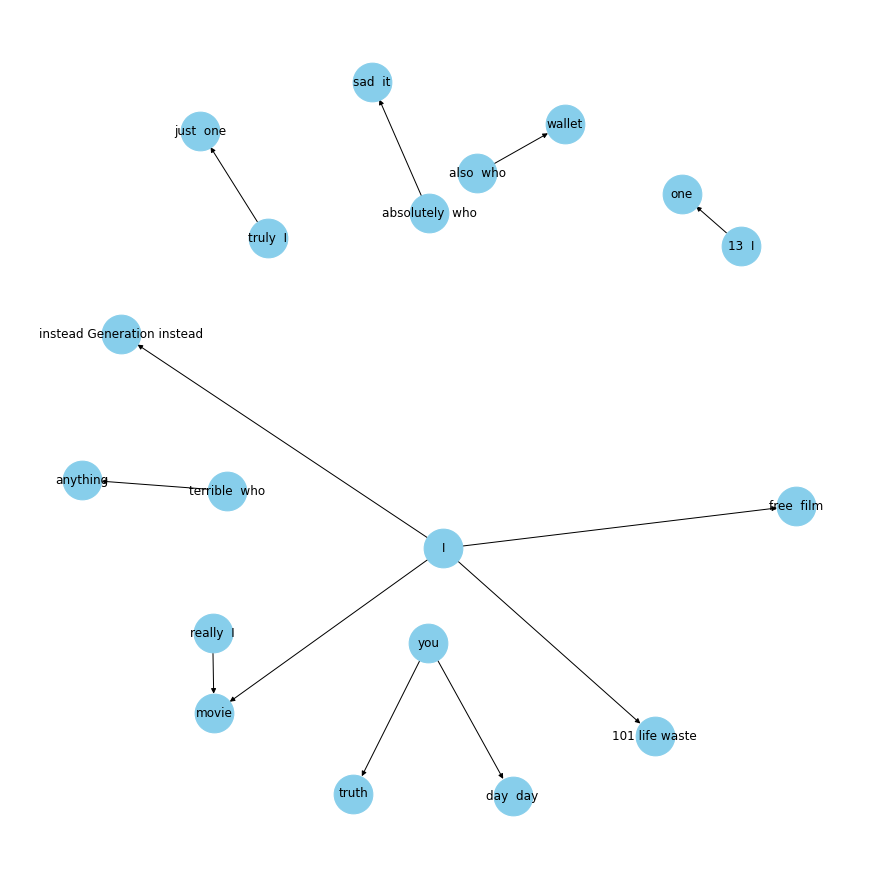

In [22]:
neg_graph= nx.from_pandas_edgelist(neg_kg_df[neg_kg_df['edge'] == 'recommend'], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(neg_graph, k = 0.5) # k regulates the distance between nodes
nx.draw(neg_graph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

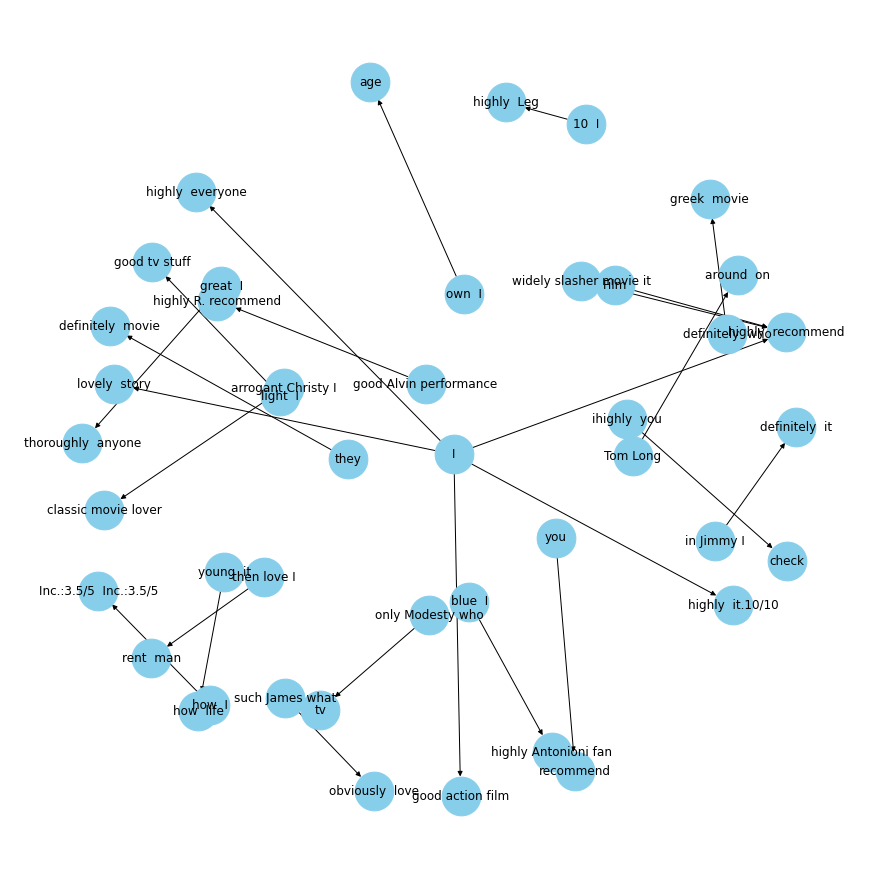

In [23]:
pos_graph = nx.from_pandas_edgelist(pos_kg_df[pos_kg_df['edge'] == 'recommend'], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(pos_graph, k = 0.5) # k regulates the distance between nodes
nx.draw(pos_graph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

##### We will work with concantanated dataframe and remove punctuation symbols from each review using  ```string.punctuations```

In [24]:
# full_review_df['review'] = full_review_df['review'].apply(utils.clean_punctuation)
# full_review_df['review'] = full_review_df['review'].apply(utils.clean_stop_words)

#### Stop words removal 

In [25]:
full_review_df['review'] = full_review_df['review'].apply(utils.remove_stop_words)

In the dataset BOW files with dictionary was provided, but we couldn't map all the files and proper indexing was confusing. Thus, we proceeded our trafsformations with CountVectorizer for box-of-words matrix and TfidfTransformer for term-frequency times inverse document-frequency representation. 

In [26]:
bow_transformer = CountVectorizer(analyzer=utils.get_full_text_process).fit(full_review_df['review'])
print(f"A mapping of terms to feature indices: {len(bow_transformer.vocabulary_)}")

A mapping of terms to feature indices: 16974


In [27]:
messages_bow = bow_transformer.transform(full_review_df['review'])

print('Shape of Sparse Matrix: ',messages_bow.shape)
print('Amount of non-zero occurences:',messages_bow.nnz)

Shape of Sparse Matrix:  (1000, 16974)
Amount of non-zero occurences: 95322


In [28]:
# term weighting and normalization with TF-IDF
tfidf_transformer=TfidfTransformer().fit(messages_bow)
messages_tfidf=tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(1000, 16974)


After obtaning bow matrix and transofrming this matrix with tf-idf representation we trained support vector machine classifier

Firstly, the model was checked on train data- and it perfectly predict the data used for training. Then we split the data to train and test and run pipeline with all transformations and SVC model. 
Obtained accuracy 81%, and confusion matrix is presented. (Could not figure out why plotted matrix is transposed)

In [29]:
review_classifier = SVC()
review_classifier.fit(messages_tfidf, full_review_df['sentiment'])
predictions = review_classifier.predict(messages_tfidf)

In [30]:
print(classification_report(full_review_df['sentiment'], predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [31]:
fig = ff.create_annotated_heatmap(confusion_matrix(full_review_df['sentiment'], predictions))
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )
fig.show()

In [32]:
train, test, label_train, label_test = train_test_split(full_review_df['review'], full_review_df['sentiment'], test_size=0.2, random_state=1863)

In [33]:
svc_pipeline = Pipeline([
   ( 'bow', CountVectorizer(analyzer=utils.get_full_text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),
])

In [34]:
svc_pipeline.fit(train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function get_full_text_process at 0x1611a3490>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [35]:
preds = svc_pipeline.predict(test)


In [36]:
fig = ff.create_annotated_heatmap(confusion_matrix(label_test, preds))
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )
fig.show()

In [37]:
print(classification_report(label_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        91
           1       0.88      0.85      0.87       109

    accuracy                           0.85       200
   macro avg       0.85      0.86      0.85       200
weighted avg       0.86      0.85      0.86       200



This model is used as benchmark. 

### Further we trained BERT model. 

BERT stands for Bidirectional Encoder Representations from Transformers. BERT is basically an Encoder stack of transformer architecture. A transformer architecture is an encoder-decoder network that uses self-attention on the encoder side and attention on the decoder side.

Firstly, install libraries

In [38]:
!pip3.10 install pytorch-pretrained-bert pytorch-nlp 


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


Remove punctuation and add special tokens at the begining and at the end of a review for BERT modeling 

In [39]:
sentences = full_review_df['review'].values
labels = full_review_df.sentiment.values

### Bert tokenizer 
In our example it is better to use cased tokenizer since a lot of names are presented, but it too resource consuming

In [40]:
full_review_df['review'] = full_review_df['review'].apply(utils.clean_punctuation)
reviews = full_review_df.review.values
reviews = [f"[CLS] {review} [SEP]" for review in reviews]
labels = full_review_df.sentiment.values
# full_review_df = pd.concat([neg_df,pos_df], ignore_index=True)
# reviews = full_review_df.review.values
# reviews = [f"[CLS] {review} [SEP]" for review in reviews]
# labels = full_review_df.sentiment.values

In [41]:
# for each input BERT requier: input ids, segment mask, attention mask, labels
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)


tokenizer.model_max_length = 1024

tokenized_texts = [tokenizer.tokenize(sent) for sent in reviews]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

The pre-trained model you are loading is an uncased model but you have set `do_lower_case` to False. We are setting `do_lower_case=True` for you but you may want to check this behavior.


Tokenize the first sentence:
['[CLS]', 'work', 'one', 'good', 'shakespeare', 'source', 'film', 'manage', 'credit', '##able', 'source', 'whilst', 'still', 'appeal', 'wide', 'audience', 'bran', '##agh', 'steal', 'film', 'fish', '##burn', '##e', 's', 'nose', 'talented', 'cast', 'good', 'form', '[SEP]']


In [42]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=512, dtype="long", truncating="post", padding="post")

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (675 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (610 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (770 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (729 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (552 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [43]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [44]:

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, 
                                                            random_state=1863, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=1863, test_size=0.2)

In [45]:
# train, test, label_train, label_test

In [46]:
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)
train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)

In [47]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data, replacement=True)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=config.BATCH_SIZE)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=config.BATCH_SIZE)

In [48]:
from pytorch_transformers import AdamW, WarmupLinearSchedule
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.config.max_position_embeddings = 1024

In [49]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {
        'params': [
            p
            for n, p in param_optimizer
            if all(nd not in n for nd in no_decay)
        ],
        'weight_decay_rate': 0.01,
    },
    {
        'params': [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        'weight_decay_rate': 0.0,
    },
]


In [50]:
# num_total_steps = 1000
# num_warmup_steps = 50
optimizer = AdamW(model.parameters(), lr=1e-3, correct_bias=True)  # To reproduce BertAdam specific behavior set correct_bias=False
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

#optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

In [51]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [52]:
t = []
train_loss_set = []
epochs = 2

for _ in trange(epochs, desc="Epoch"):
    model.train()


    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())
        loss.backward()
        # scheduler.step()
        optimizer.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print(f"Train loss: {tr_loss / nb_tr_steps}")




# Validation
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print(f"Validation Accuracy: {eval_accuracy / nb_eval_steps}")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.8129188108444214


Epoch:  50%|█████     | 1/2 [1:51:44<1:51:44, 6704.18s/it]

Validation Accuracy: 0.45982142857142855
Train loss: 0.7147216749191284


Epoch: 100%|██████████| 2/2 [3:47:55<00:00, 6837.84s/it]  

Validation Accuracy: 0.45982142857142855


Running 2 epochs took 3 hours. The solution diverged on the second epochs and dropped less the 50% - perfomance of trained model worse than random pick up. As we figure out all predicted values equal to 0. I assume that the main issue related to the BERT's input size. It is limited with 512 symbols for the input, that is why huge part of information is lost. 

For validation we run BERT on test data that was used for SVC model 

In [53]:
test[:5]

749    VIVAH opinion good movie 2006 , come director ...
977    clara bow 's beauty wonderful appeal chief rea...
468    apparently none previous reviewer , praise fil...
356    wow ... I pick local Wal - Mart read online re...
365    I see quite positive review board , try revive...
Name: review, dtype: object

In [54]:
test_labels[:5]

tensor([1, 1, 0, 0, 0])

In [55]:
test_review = [f"[CLS] {review} [SEP]" for review in test]
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_review]

In [56]:
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids_test = pad_sequences(input_ids_test, maxlen=config.MAX_LEN, dtype="long", truncating="post", padding="post")

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (548 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (523 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (541 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (549 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (557 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [57]:
attention_masks_test = []
for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

In [58]:
test_prediction_inputs = torch.tensor(input_ids_test)
test_prediction_masks = torch.tensor(attention_masks_test)
test_prediction_labels = torch.tensor(test_labels)

In [59]:
prediction_data = TensorDataset(test_prediction_inputs, test_prediction_masks, test_prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=config.BATCH_SIZE)

In [60]:
# Prediction on test set
model.eval()
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

In [61]:
preds = [np.argmax(prediction, axis=1).flatten() for prediction in predictions]
preds = [item for sublist in preds for item in sublist]

In [62]:
fig = ff.create_annotated_heatmap(confusion_matrix(preds, test_labels))
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )
fig.show()